<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Examen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Regresion Avanzada 18/07/2023
## Alumno: Andres Montes de Oca

### Librerias Python

In [ ]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import math

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=0.5, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

#### Librerias R

In [ ]:
%%R

## MVN Henze-Zirkler Test ### -> Lento
# system(sudo apt install libgsl-dev)
# install.packages('MVN')

# ## QQ Plot, Bonferroni, outlierTest, vif, leveneTest ###
# install.packages('car') # 10 min

# # Kruskal-Wallis Multiple Comparation ###
# install.packages('pgirmess') # 12 Min

# # Metodos de Regularizacion y Reg Logistica ### ->
# install.packages('glmnet') # 5 mins

# # Estimaciones Robustas ### ->
# install.packages('quantreg') # LAD 3:30 Min
# install.packages('robustbase') # lmrob Rapido
# install.packages('olsrr') # 6 mins

#######################################
# # Herramienta para ANOVA ###
# install.packages('lsr') # Rapido
# install.packages('gridExtra') # Rapido

# # Wald Test ###
# install.packages('aod') # Rapido

# # LRM Tests ###
# install.packages('lmtest') # Rapido

# # Box-Cox Transformation ### -> Rapido
# install.packages('MASS') # Rapido, Huber, LTS

# # Seleccion de Variables ### -> Rapido
# install.packages('leaps') # -> regsubsets

# # Test Hosmer-Lemeshow Regresion Logistica ### ->
# install.packages('ResourceSelection') # Rapido

# # Metodos de vcd ### ->
# install.packages('vcd') # Rapido

# # ROC Curve ### ->
# install.packages('pROC') # 1 min

# # Metodos de PCA ### -> Rapido
# install.packages('pls')

# install.packages('splitstackshape')

# install.packages("Metrics")

# install.packages('gridExtra')

#### Carga de Datos desde Google Drive

In [17]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

######################################################
# pancreas
id = '18NKGgoamjSZtyRRkh_2qaKzMAgCv8aYu'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('pancreas.csv')
data = pd.read_csv('pancreas.csv', sep=';')
%R -i data



# Analisis Exploratorio para entender las variables

In [20]:
display(data.head())
print(data.info())

,paciente,edad,sexo,diagnosis,estadio,creatinina,LYVE1,REG1B,TFF1
0,S1,33,F,normal,NO,"1,83222000","0,89321920","52,94884000","654,28217400"
1,S10,81,F,normal,NO,"0,97266000","2,03758500","94,46703000","209,48825000"
2,S100,51,M,normal,NO,"0,78039000","0,14558890","102,36600000","461,14100000"
3,S101,61,M,normal,NO,"0,70122000","0,00280488","60,57900000","142,95000000"
4,S102,62,M,normal,NO,"0,21489000","0,00085956","65,54000000","41,08800000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paciente    382 non-null    object
 1   edad        382 non-null    int64 
 2   sexo        382 non-null    object
 3   diagnosis   382 non-null    object
 4   estadio     382 non-null    object
 5   creatinina  382 non-null    object
 6   LYVE1       382 non-null    object
 7   REG1B       382 non-null    object
 8   TFF1        382 non-null    object
dtypes: int64(1), object(8)
memory usage: 27.0+ KB
None


- LA unica variable numerica es edad, las otras son texto. Vamos a tener que transofrmarlas

#### Transformacion de Variables

In [40]:
# Variables String a transformar a Float
numeric = ['creatinina', 'LYVE1', 'REG1B', 'TFF1']
category = ['sexo', 'diagnosis', 'estadio']

# Reemplazo coma por punto, luego transformo a float
# data[numeric] = data[numeric].replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
# data[numeric] = data[numeric].astype('float') # Transformo en float

# Transformo los Strings a categoricas
# data[category] = data[category].astype('category')

# Mostramos los datos transofrmados
# print(data.info())

# Confirmamos que los ID de paciente no se repiten
# print('\nID Pacientes unicos:', data.paciente.is_unique)

# Exportamos a R
# %R -i data

data.head()

,paciente,edad,sexo,diagnosis,estadio,creatinina,LYVE1,REG1B,TFF1
0,S1,33,F,normal,NO,1.83222,0.893219,52.94884,654.282174
1,S10,81,F,normal,NO,0.97266,2.037585,94.46703,209.488250
2,S100,51,M,normal,NO,0.78039,0.145589,102.36600,461.141000
3,S101,61,M,normal,NO,0.70122,0.002805,60.57900,142.950000
4,S102,62,M,normal,NO,0.21489,0.000860,65.54000,41.088000


In [54]:
# Estratificamos en R
%%R

# library(splitstackshape)

set.seed(1515)
data <- stratified(data, 'diagnosis', 300/nrow(data))

In [56]:
# Improtamos a Python

%R -o data

print(data.shape)
display(data.head())

(300, 9)


,paciente,edad,sexo,diagnosis,estadio,creatinina,LYVE1,REG1B,TFF1
1,S180,71,1,2,5,0.26013,0.000129,5.225890,0.129430
2,S66,62,1,2,5,0.21489,1.228042,9.421916,0.016761
3,S49,58,1,2,5,1.73043,5.113560,143.875900,515.300000
4,S86,72,1,2,5,0.32799,0.406951,125.125000,158.943000
5,S115,55,2,2,5,1.28934,2.285351,67.468000,269.805000


# Ejercicio #1: Regresion Lineal

#### Analisis de Correlacion entre las Variables

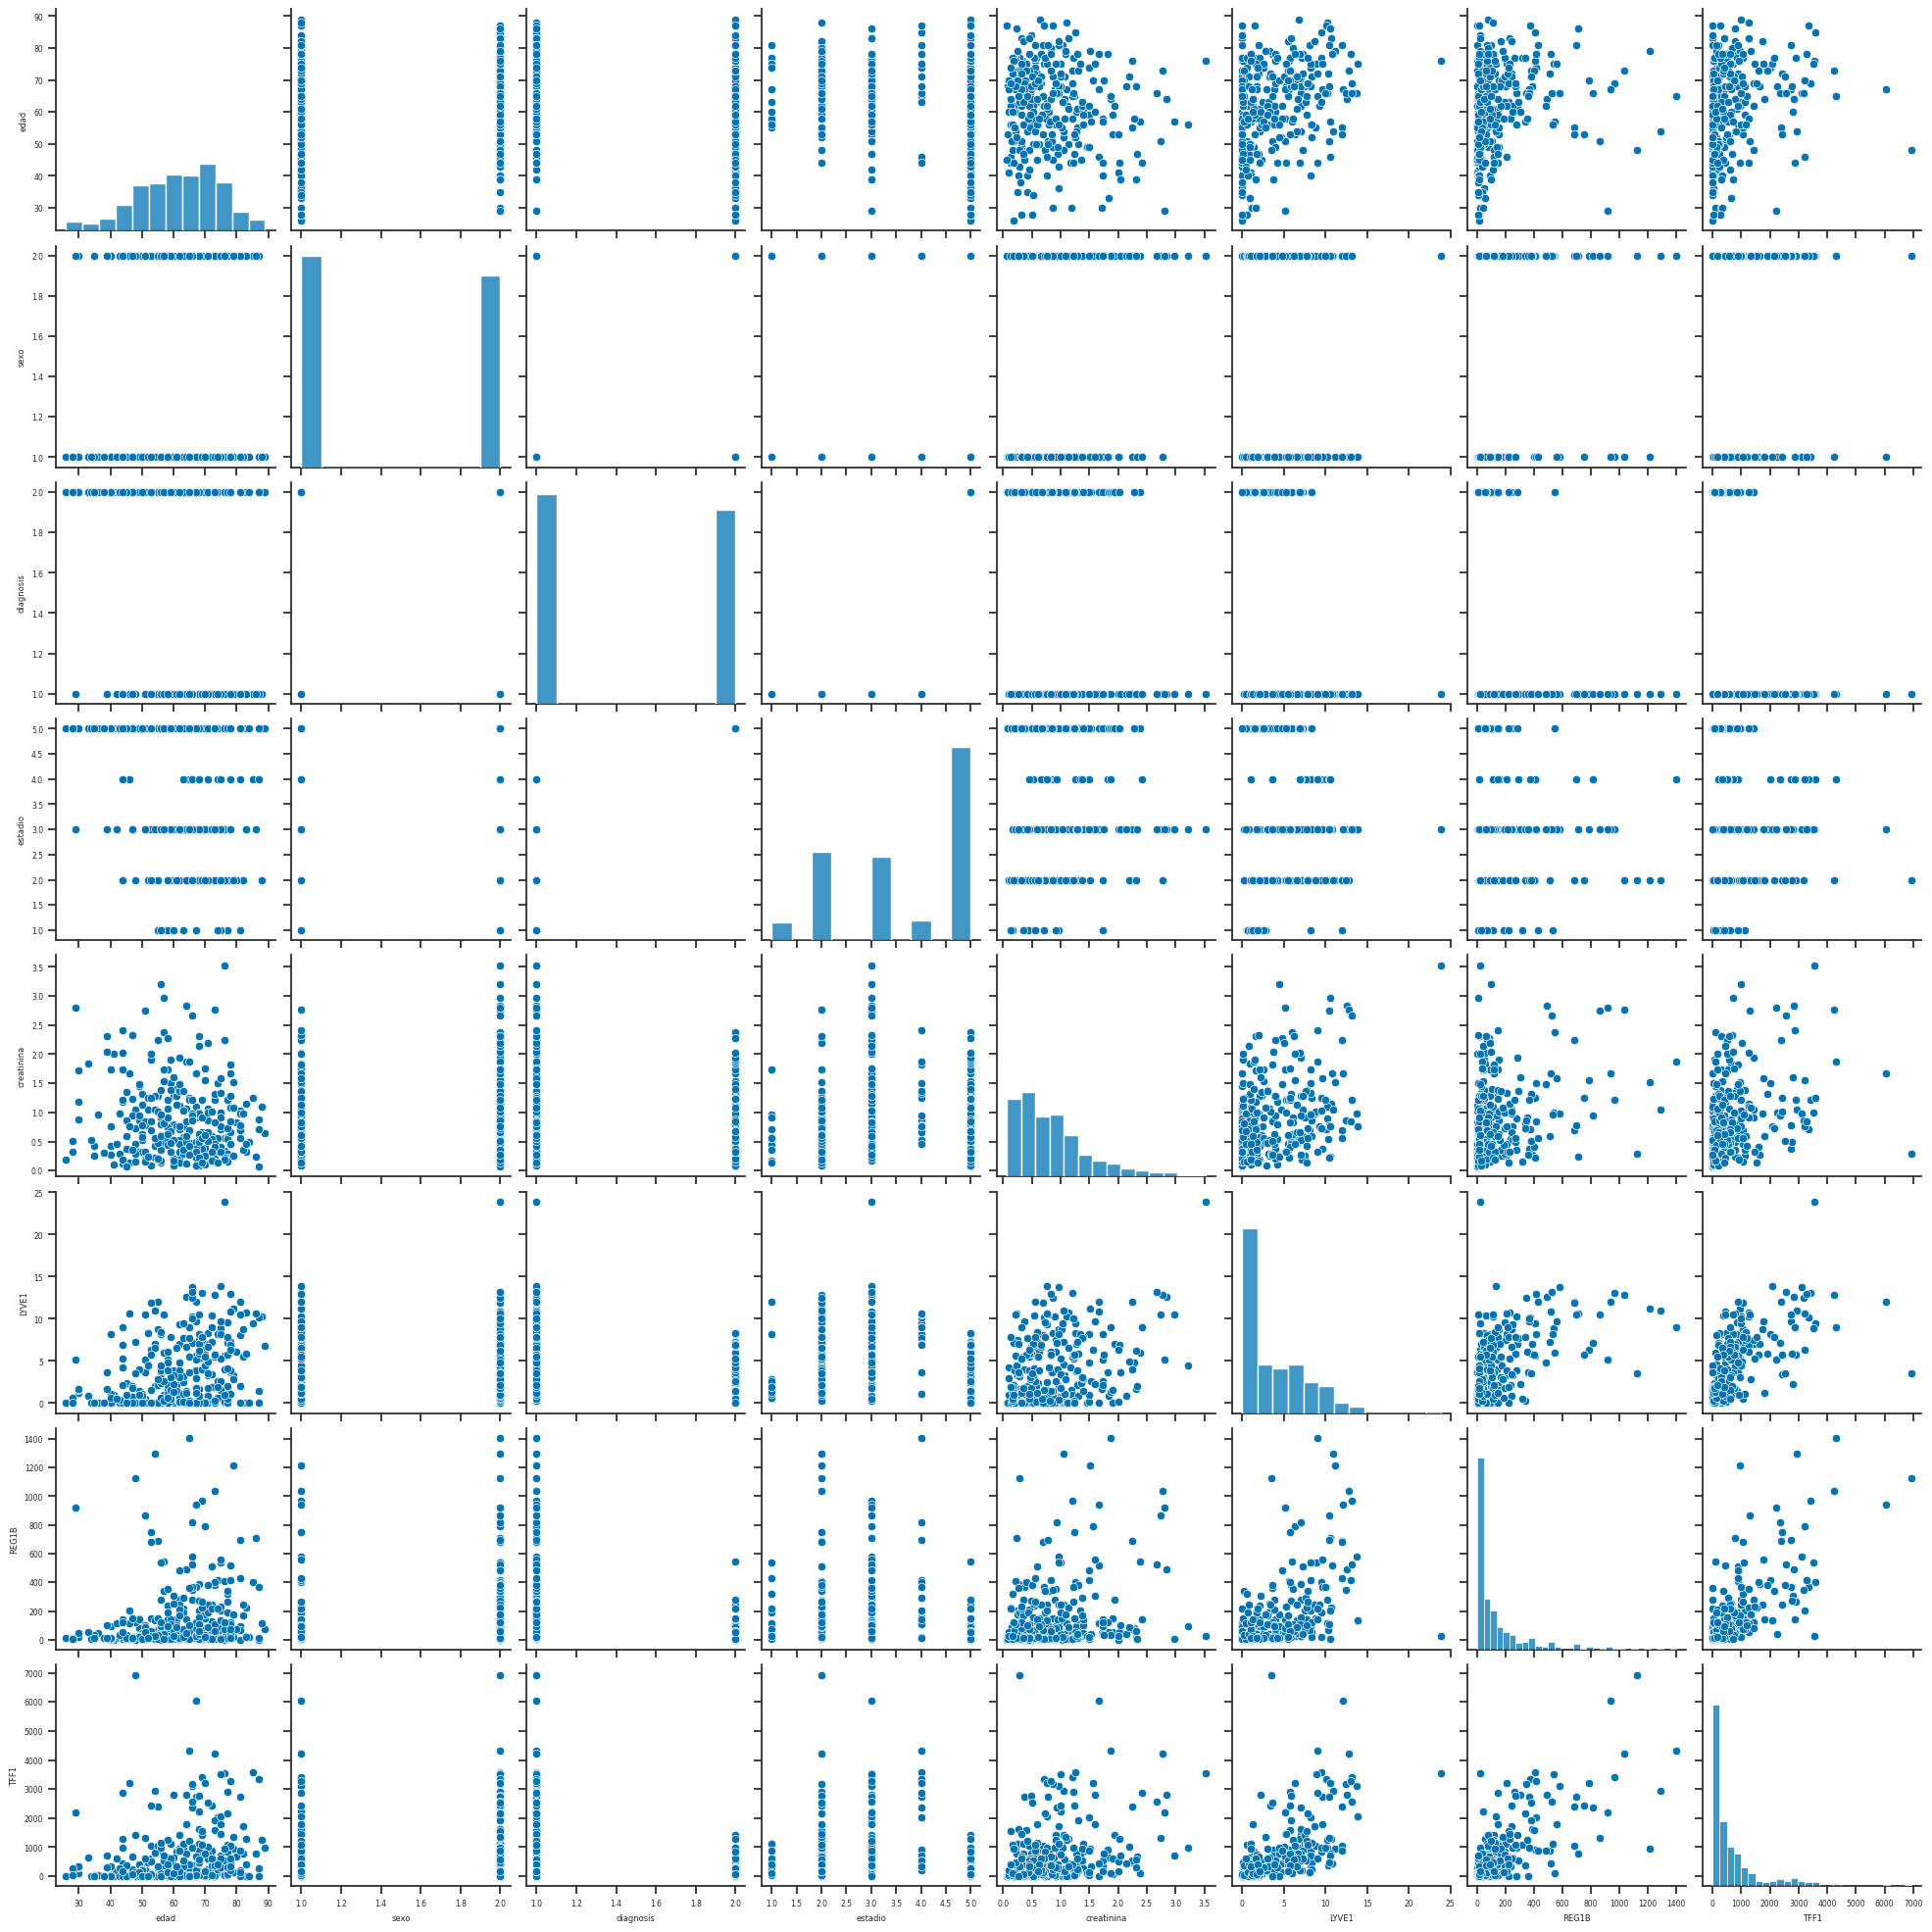

In [68]:
# Graficos de Dispersion entre las Variables
sns.pairplot(data=data)
plt.show()

<Axes: >

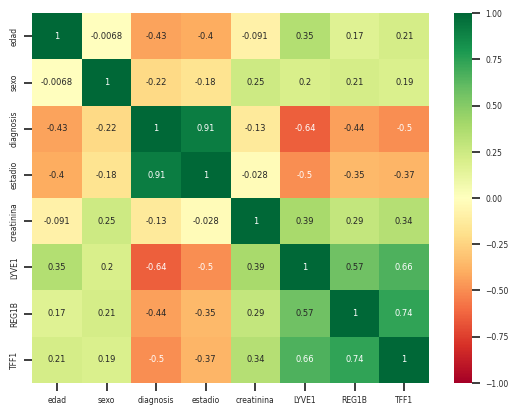

           n         r         CI95%         p-val       BF10  power
pearson  300  0.385474  [0.28, 0.48]  4.583665e-12  1.583e+09    1.0


In [62]:
# Analizamos la Correlacion de las variables
display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos
plt.show()

# Test de Indepdencia de Pearson
print(pg.corr(data['creatinina'], data['LYVE1'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes

- Analizamos la Correlacion entre las variables, y se verifica que la que esta mas fuertemente correlacionada con Creatinina es la Proteina LYVE1 (0.39)
- Lo confirmamos con el Test de Pearson, rechazando la Hipotesis Nula de que las Variables son Independientes

#### Modelo Lineal Simple Creatinina ~ LYVE1

In [63]:
# Linear Regression
%%R

model <- lm('creatinina ~ LYVE1', data=data)
resid <- model$resid
fitted <- model$fitted.values

print(summary(model))


Call:
lm(formula = "creatinina ~ LYVE1", data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0653 -0.4504 -0.1634  0.2831  2.3034 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.623423   0.047893  13.017  < 2e-16 ***
LYVE1       0.063642   0.008825   7.212 4.58e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5997 on 298 degrees of freedom
Multiple R-squared:  0.1486,	Adjusted R-squared:  0.1457 
F-statistic: 52.01 on 1 and 298 DF,  p-value: 4.584e-12



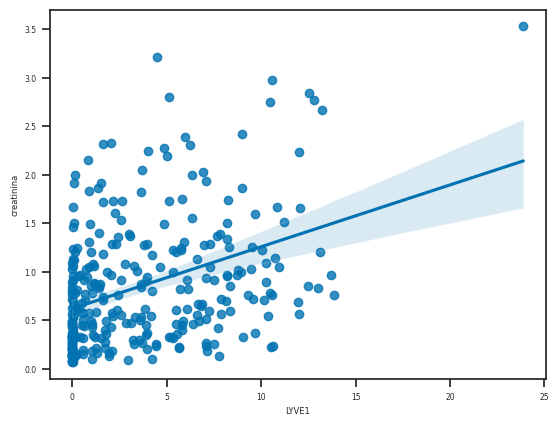

In [66]:
# # Graficamos en Python

sns.regplot(data=data, x='LYVE1', y='creatinina')
plt.show()

- El Test de Wald indica que la variable LYVE1 es por demas significativa en el modelo
- El Test de la Regresion tambien indica que el modelo es significativo
- El problema lo tenemos con el Coeficiente de Determinacion R2, el cual es muy bajo (0.146), indicando que la proporcion de variabilidad explicada por el modelo es muy baja
- En el Grafico de Dispersion se observa que el Fit del modelo no es bueno

### Analisis de Diagnostico

#### Normalidad de Residuos


	Shapiro-Wilk normality test

data:  model$resid
W = 0.9251, p-value = 3.967e-11



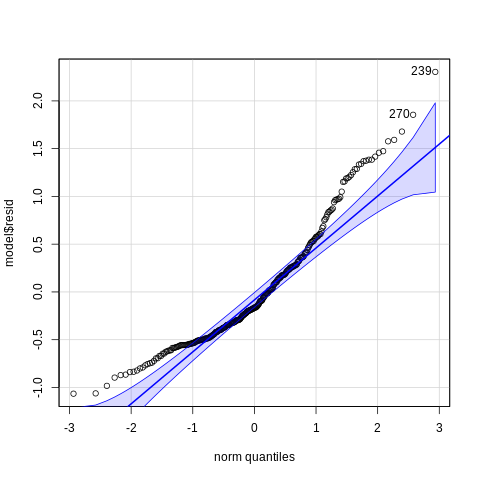

In [69]:
%%R

# Analisis de Normalidad en los Residuos
library(car)
qqPlot(model$resid) # Observaciones que romperian con el supuesto de Normalidad
print(shapiro.test(model$resid))

- Realizamos un Test de Normalidad de Shapiro, y confirmamos que hay suficiente evidencia para recahzar la Hipotesis Nula de que los residuos estan distribuidos Normalmente
- Lo confirmamos con un QQ Plot, viendo como muchos resiudos no estan contenidos en el Intervalo de Confianza
- Tambien confirmamos la presencia de dos posibles valores atipicos, las observaciones #239 y #270
- **Los residuos NO estan distribuidos normalmente**

#### Homocedasitcidad de Residuos

In [71]:
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

# library(lmtest)

bptest(model)


	studentized Breusch-Pagan test

data:  model
BP = 15.802, df = 1, p-value = 7.034e-05



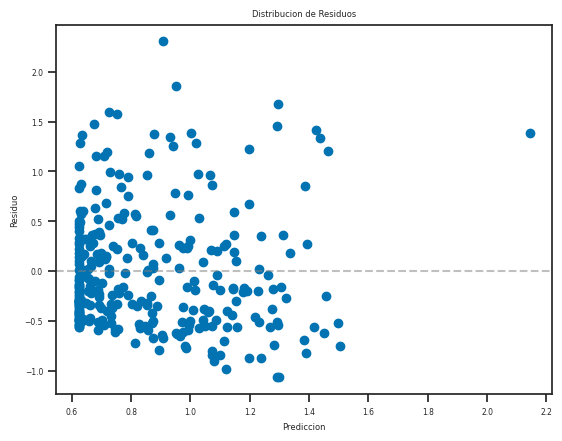

In [72]:
# # Analsis Grafico -> Python

# Importamos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()

- Realizamos el Test de Breusch-Pagan, y confirmamos que con el p-value obtenido (7.034e-05) rechazamos la Hipotesis Nula de que los reisudos son Homocedasticos
- Lo confirmamos en el analisis grafico, se puede observar la estructura de embudo, lo que indica que la varianaza de los residuos no es constante
- **Los residuos NO son Homocedasticos**

#### Autocorrelacion de Residuos

In [73]:
# Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
%%R

library(lmtest)

dwtest(model, alternative='two.sided', iterations=1000)


	Durbin-Watson test

data:  model
DW = 1.8503, p-value = 0.1848
alternative hypothesis: true autocorrelation is not 0



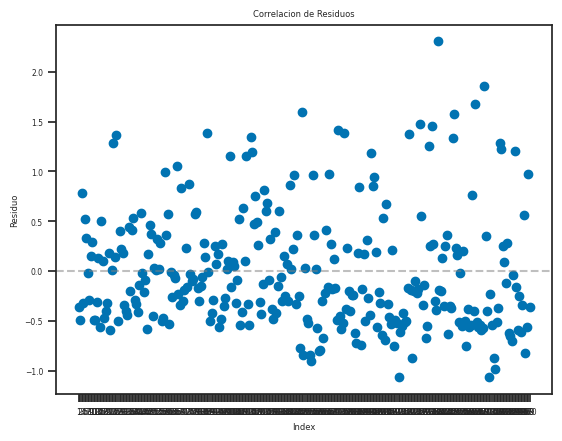

Durbin-Watson: 1.850315966938328


In [74]:
# Analsis Grafico -> Python

plt.scatter(x=data.index, y=resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()

# Analisis Analitico -> Python
print('Durbin-Watson:', sm.stats.durbin_watson(resid)) # Sin validacion Estadistica

- Realizamos el Test de Durbin-Watson, y con un alpha del 5% no hay suficiente evidencia para rechazar la Hipotesis Nula de la No-Autocorrelacion de Residuos.
- Lo confirmamos con la graifica de Residuos vs Indices. No se observa ningun tipo de patron en los datos
- **No existe Auto-Crrelacion en los residuos**

### Outliers y Puntos Influyentes

#### Deteccion de Outliers

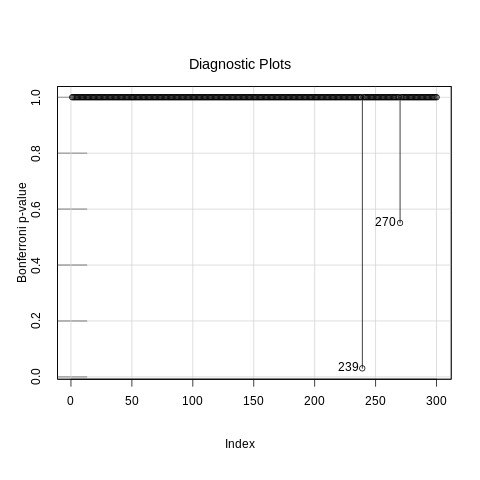

In [76]:
%%R

library(car)

# Outliers - Bonferroni
outlierTest(model)
influenceIndexPlot(model, vars='Bonf')

- Realizamos el Test de Bonferroni, y vemos que las observciones #239 y #270 estan marcadas como potenciales Outliers
- Son las mismas dos observaciones indicadas en el QQ Plot de los residuos

#### Puntos Influyentes

#### Hat Values

            V1 crit_leverage leverage
147 0.02232018          0.02        1
173 0.02011911          0.02        1
177 0.09117100          0.02        1
212 0.02486686          0.02        1
249 0.02104642          0.02        1
258 0.02538222          0.02        1
286 0.02192259          0.02        1
290 0.02269149          0.02        1


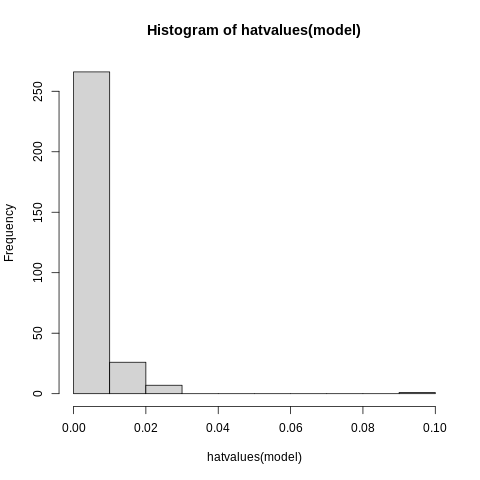

In [84]:
# Influyentes - Leverage
%%R

crit_leverage <- 3*mean(hatvalues(model))
leverage <- hatvalues(model) > crit_leverage
leverage_data <- data.frame(cbind(hatvalues(model), crit_leverage, leverage))

hist(hatvalues(model))
print(subset(leverage_data, leverage==1))

- Observamos la mayoria de las observaciones tienen una medida de apalancamiento (hatvalues) menores o iguales a 0.02
- Las observaciones #147, #173, #177, #212, #249, #258, #286 y #290 superan ese umbral de 0.02. Las marcamos como posibles candidatas de valores influyentes
- La observacion #177 parece ser la mas influyente de todas, es la que mas me va a influir en el calulo de los Betas

#### Cook Distance

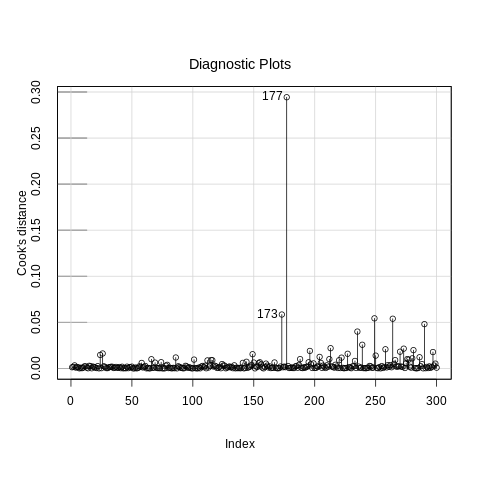

In [88]:
# Influyentes - Cook
%%R

# print(cooks.distance(model))
influenceIndexPlot(model, vars='Cook')

- Nuevamente la observacion #177 como candidata por la gran distancia de Cook
- Tambien la #173 se marcada

#### DFFITS

In [90]:
# Influyentes - DFFITS
%%R

p <- length(model$coef)
n <- NROW(model$resid)
dffits_crit <- 2*sqrt(p/n)
dffits <- dffits(model)
data_dffits <- data.frame(dffits=dffits)

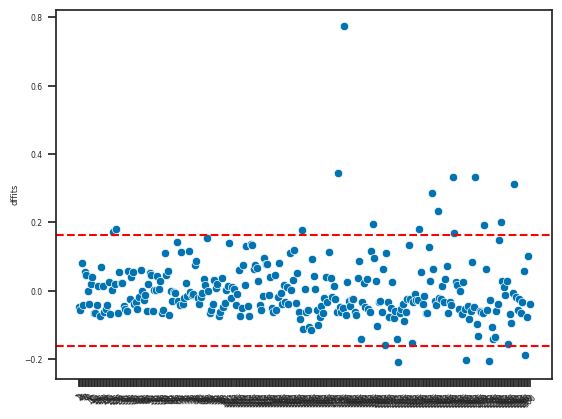

,dffits
24,0.171755
26,0.181005
149,0.176945
173,0.344619
177,0.773575
196,0.194892
213,-0.209888
227,0.179483
235,0.284992
239,0.231808


In [91]:
# DFFITS Grafico -> Python
%R -o data_dffits
%R -o dffits_crit

# Grafico
data_dffits.head()
sns.scatterplot(data=data_dffits, x=data_dffits.index, y='dffits')
plt.axhline(y=dffits_crit, linestyle='--', color='red')
plt.axhline(y=-dffits_crit, linestyle='--', color='red')
plt.xticks(rotation=45)
plt.show()

# Filtro los criticos
dffits_crit_low = -dffits_crit
dffits_crit_up = dffits_crit

display(data_dffits.query('dffits > @dffits_crit_up or dffits < @dffits_crit_low'))

- Analizamos los DFFITS para ver que tan influyentes son las observaciones para estimarse a si mismas.
- Se observan bastantes observaciones que pasan el umbral definido de 2*sqrt(p/n), pero las dos con mayor diferencia son las mismas #177 y #173

### Conclusion de Outliers y Valores Influyentes
- Dos observaciones son claros Valores Influyentes, lo que quiere decir que su prescencia modifica considerablemnte la estructura de la recta de regresion. Estas indicaciones son las #177 y #173
- Tambien se observaron dos Outliers, observaciones #239 y #270, pero estas no parecen ser influyentes, solo Outliers. No deberian influir en el calculo de la reta de regresion
- **El Modelo no es adecuado. El coeficiente de Determinacion es muy pequeno, no se satisfacen los supuestos del modelo de Normalidad ni el de Homocedasticidad e los Resiudos, lo que indica que no se pueden inferencias confiables sobre datos nuevos. Ademas habria que hacer algun tipo de tratamiento a las observaciones marcadas como Valores Influyentes**

### Transformacion Box-Cox

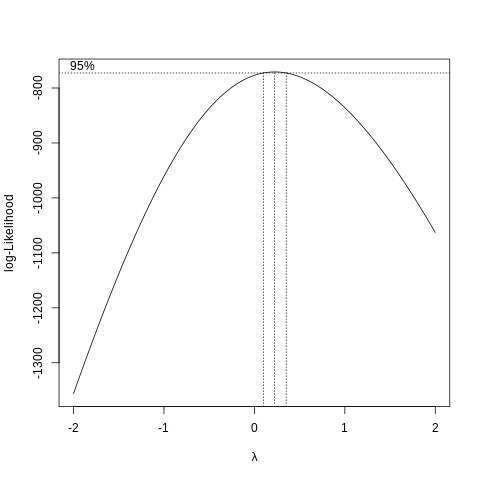

In [92]:
# Box Cox Transformation -> R
%%R

library(MASS)

# Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
boxcox(object = model, plotit=TRUE)

- Confirmamos con el test de Box y Cox, que el lambda optimo para la transformacion de la variable respuesta es 0
- Al ser el Lambda igual a 0, la transformacion recomendad es el Logaritmo en base 10 de la variable respuesta

In [93]:
# # Generamos el nuevo modelo con las nueva variable transformada, y veridicamos su Normalidad
%%R


model_2 <- lm('log10(creatinina) ~ LYVE1', data=data)
print(shapiro.test(model_2$resid))


	Shapiro-Wilk normality test

data:  model_2$resid
W = 0.98299, p-value = 0.001256



- Realizamos el test de Normalidad de Shapiro a los residuos del modelo transofrmado, y confirmamos que con un alpha del 5% hay suficiente evidencia para rehazar la Hipotesis Nula sobre la distribucion Normal de los datos
- **Los residuos del nuevo modelo transformado NO se distribuyen normalmente, el modelo no es adecuado para hacer inferenias**

### Modelos Robustos

In [99]:
data.head()

,paciente,edad,sexo,diagnosis,estadio,creatinina,LYVE1,REG1B,TFF1
1,S180,71,1,2,5,0.26013,0.000129,5.225890,0.129430
2,S66,62,1,2,5,0.21489,1.228042,9.421916,0.016761
3,S49,58,1,2,5,1.73043,5.113560,143.875900,515.300000
4,S86,72,1,2,5,0.32799,0.406951,125.125000,158.943000
5,S115,55,2,2,5,1.28934,2.285351,67.468000,269.805000


In [117]:
%%R

# library(MASS)
# library(quantreg)
# library(Metrics)

# Huber: Menos peso a residuos grandes. Cuadratica que empalma con lineal
model_Huber <- rlm(creatinina ~ LYVE1 + TFF1, data=data, k2=1.345)
print(summary(model_Huber))

# Calculo del MAE del nuevo modelo
print(mae(data$creatinina, model_Huber$fitted.values))

# Calulo del MAE del modelo original
print(mae(data$creatinina, model$fitted.values))


Call: rlm(formula = creatinina ~ LYVE1 + TFF1, data = data, k2 = 1.345)
Residuals:
    Min      1Q  Median      3Q     Max 
-1.2011 -0.3808 -0.0801  0.3700  2.3551 

Coefficients:
            Value   Std. Error t value
(Intercept)  0.5909  0.0425    13.9175
LYVE1        0.0344  0.0104     3.2967
TFF1         0.0001  0.0000     2.7770

Residual standard error: 0.5616 on 297 degrees of freedom
[1] 0.4560944
[1] 0.4732359


- Vemos como el Mean Absolute Error del modelo nuevo (robusto multivariado), es algo mejor que el del original (modelo lienal simple)

### Seleccion de Variables

In [133]:
# BEST SUBSET
%%R
library(leaps)

# Modelo Best Subset -> Consideramos todos los subconjuntos de variables predictoras posibles
model_todos <- regsubsets(creatinina ~ LYVE1 + TFF1 + REG1B + edad + sexo + diagnosis , data=data, nvmax=6) # Hasta 6 Variables
model_todos_summary <- summary(model_todos)
print(model_todos_summary)

# Generamos el DataSet y vemos que coeficientes elligio
data_model_todos <- data.frame(orden=1:6, adjr2=model_todos_summary$rsq, Cp=model_todos_summary$cp, Bic=model_todos_summary$bic)
print(data_model_todos)
print(which.max(model_todos_summary$adjr2))
print(which.min(model_todos_summary$cp))
print(which.min(model_todos_summary$bic))

Subset selection object
Call: regsubsets.formula(creatinina ~ LYVE1 + TFF1 + REG1B + edad + 
    sexo + diagnosis, data = data, nvmax = 6)
6 Variables  (and intercept)
                Forced in Forced out
LYVE1               FALSE      FALSE
TFF1                FALSE      FALSE
REG1B               FALSE      FALSE
edad                FALSE      FALSE
sexoM               FALSE      FALSE
diagnosisnormal     FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         LYVE1 TFF1 REG1B edad sexoM diagnosisnormal
1  ( 1 ) "*"   " "  " "   " "  " "   " "            
2  ( 1 ) "*"   " "  " "   "*"  " "   " "            
3  ( 1 ) "*"   " "  " "   "*"  "*"   " "            
4  ( 1 ) "*"   " "  " "   "*"  "*"   "*"            
5  ( 1 ) "*"   "*"  " "   "*"  "*"   "*"            
6  ( 1 ) "*"   "*"  "*"   "*"  "*"   "*"            
  orden     adjr2        Cp       Bic
1     1 0.1485900 38.987881 -36.85087
2     2 0.2067806 18.092734 -52.38529
3     3 0.2315580 10.3440

- Utilizamos Best Subset para analizar todos los modelos posibles
- Elegimos el modelo con que genera el menor BIC con 3 variables
- Podriamos haber elgido el modelo de 5 variables con el menor CP y Mayor R2, pero preferimos tener menor variables en el modelo para su mas sencilla explicabilidad

#### Explicaion de los coeficientes

In [144]:
%%R

print(coef(model_todos, 3))

# No se como elegir el modelo #3 del model_todos, asi que lo genero a mano
model_selected <- lm(creatinina ~ LYVE1 + edad + sexo, data=data)
print(coef(model_selected))

# resid <- model_selected$resid
# fitted <- model_selected$fitted.values

(Intercept)       LYVE1        edad       sexoM 
 1.23842642  0.07247689 -0.01214995  0.20890063 
(Intercept)       LYVE1        edad       sexoM 
 1.23842642  0.07247689 -0.01214995  0.20890063 


- El valor estimado de la creatinina aumeta en los Hombres mas jovenes, como asi tambien en las personas con valores de proteina LYVE1 mas elevados

#### Analisis de Diagnostico de model_selected


	Shapiro-Wilk normality test

data:  model_selected$resid
W = 0.9565, p-value = 8.63e-08

[1] 239 220


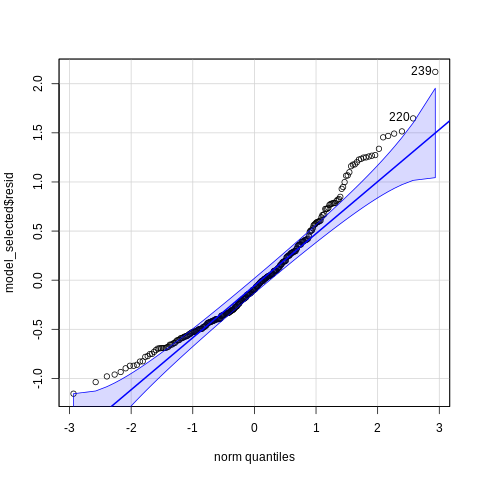

In [146]:
%%R

# Analisis de Normalidad en los Residuos
print(shapiro.test(model_selected$resid))
qqPlot(model_selected$resid)

- Se rechaza la Hipotesis Nula de Normalidad de los residuos, el p=value es muy pequeno

In [147]:
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

bptest(model_selected)


	studentized Breusch-Pagan test

data:  model_selected
BP = 31.835, df = 3, p-value = 5.67e-07



- Tambien se rechaza la Hipotesis Nula de Homocedasticidad de los residuos, lo confirmamos con el test de Breusch-Pagan

In [148]:
# Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
%%R

dwtest(model_selected, alternative='two.sided', iterations=1000)


	Durbin-Watson test

data:  model_selected
DW = 1.8815, p-value = 0.2933
alternative hypothesis: true autocorrelation is not 0



- No hay suficiente evidencia para rechazar la Hipotesis Nula de no-autocorrelcion de los residuos. Lo confirmamos con el test de Durbin Watson
- No me da el tiempo para analizar las transformaciones, son faltan 25 mins para que temrine el examen

### Estimacion de Errores en los modelos

In [154]:
%%R

# # Modelos Previos
# model -> Modelo Lineal Simple
# model_2 -> Modelo Transformado por box-cox (log10 de la variable dependiente)
# model_Huber -> Modelo Robusto de Huber
# model_selected -> Mejor modelo seleccionado, variables predictoras LYVE1, edad y sexo

# Calulo de los MAE de cada modelo
print(mae(data$creatinina, model$fitted.values))
print(mae(data$creatinina, model_2$fitted.values))
print(mae(data$creatinina, model_Huber$fitted.values))
print(mae(data$creatinina, model_selected$fitted.values))


[1] 0.4732359
[1] 1.056897
[1] 0.4560944
[1] 0.4496565


- Eligira model_selected, ya que no solo que es el que menor MAE tiene, sino que tambien esta conformado solo de 3 variables y es mas sencillo de explicar

# ANOVA

             Df Sum Sq Mean Sq F value   Pr(>F)    
estadio       4  10.37  2.5935   6.624 4.07e-05 ***
Residuals   295 115.51  0.3916                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


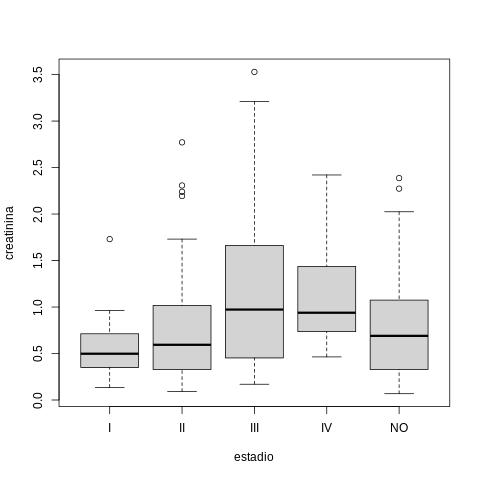

In [160]:
%%R

library(car)

# Modelamos con ANOVA -> H0: Medias de cada grupo = (Test F)
model_anova<- aov(creatinina ~ estadio, data=data)
print(summary(model_anova))

plot(creatinina ~ estadio, data=data)

- Con el p-value obtenido (4.07e-05) rechazamos la Hipotesis Nula de que cada subgrupo tiene medias similares. Esto lo confirmaremos si se cumplen los Supuestos de Normalidad y Homogeniedad de la Varianza
- Igualmente, graficamente pareciera verse que las varianzas en cada grupo son distintas, ya que en el Boxplot el tamano de cada caja es distinto

#### Validex del ANOVA

In [162]:
# ANOVA valido solo si se satisfacen los supuestos
%%R

# Test de Levene (Homocedasticidad, robusto) -> H0: Varianzas  de cada grupo =
print(leveneTest(creatinina ~ estadio, data=data))

# Test Shapiro: H0 Normalidad Distribucion de los residuos
print(shapiro.test(residuals(model_anova)))

# Conclusion del test F de ANOVA

Levene's Test for Homogeneity of Variance (center = median)
       Df F value    Pr(>F)    
group   4  6.0202 0.0001141 ***
      295                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	Shapiro-Wilk normality test

data:  residuals(model_anova)
W = 0.92962, p-value = 1.037e-10



- Realizamos el Test de Levene y vemos que hay sufuciente evidencia como para rechazar la Hipotesis Nula de que las varianzas en cad subgrupo son similares
- Tambien rechazamos la Hipotesis Nula de normalidad de los residuos

### ANOVA no-parametrico
Al no cumplirse los supuestos de Normalidad y Homocedasticidad, realizamos el ANOVA no parametrico

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


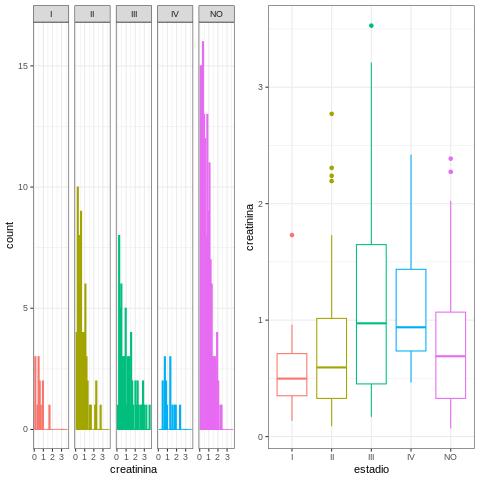

In [175]:
%%R

library(ggplot2)
library(gridExtra)

# Ploteamos para verificar las formas de las distribuciones de cada subgrupo
plot1 <- ggplot(data = data, mapping = aes(x = creatinina, colour = estadio)) +
  geom_histogram() + theme_bw() + facet_grid(. ~ estadio) +
  theme(legend.position = "none")# + stat_bin(binwidth=30)

# Y las medias de cada uno tambien
plot2 <- ggplot(data = data, mapping = aes(x = estadio, y = creatinina, colour = estadio)) +
  geom_boxplot() + theme_bw() + theme(legend.position = "none")

grid.arrange(plot1, plot2, ncol = 2)

In [174]:
# Test Kruskal-Wallis -> H0: Forma de Distribuciones =

%%R
print(kruskal.test(creatinina ~ estadio, data = data))


	Kruskal-Wallis rank sum test

data:  creatinina by estadio
Kruskal-Wallis chi-squared = 17.419, df = 4, p-value = 0.001602



- Realizamos el test de Kruskal-Wallis y observamos como hay suficiente evidencia para rechazar la Hipotesis Nula sobre la igualdad en las formas de las distribuciones de cada grupo
- Confirmamos lo anterior vendo las diferencias en el tamano de las cajas de los box-plot, como asi tambien con la prsencia de Outliers

In [176]:
# Kruskal-Wallis Multiple Comparation
%%R

library(pgirmess)
print(kruskalmc(data$creatinina ~ data$estadio))

Multiple comparison test after Kruskal-Wallis 
alpha: 0.05 
Comparisons
         obs.dif critical.dif stat.signif
I-II   23.335082     73.88747       FALSE
I-III  65.921836     74.27865       FALSE
I-IV   87.182051     92.27044       FALSE
I-NO   28.122329     70.51764       FALSE
II-III 42.586755     43.06635       FALSE
II-IV  63.846970     69.65075       FALSE
II-NO   4.787247     36.19573       FALSE
III-IV 21.260215     70.06559       FALSE
III-NO 37.799507     36.98771        TRUE
IV-NO  59.059722     66.06517       FALSE


- Ralizamos la comparacion multiple de Kurskal-Wallis, y vemos como los unicos grupos con medias distintas son el Estadio III, el grupode pacientes sanos

### ANOVA solo para pacientes enfermos

In [187]:
# Genero la nueva base de pacientes enfermos
# Al categorizar las variables, Python transformo el estadio NO a 5
data_enfermos = data.query('estadio < 5')

print('Cantidad observaciones de Enfermos:', data_enfermos.shape[0])

# Exporto a R
%R -i data_enfermos


Cantidad observaciones de Enfermos: 156


#### Anova no-parametrico para pacientes enfermos

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


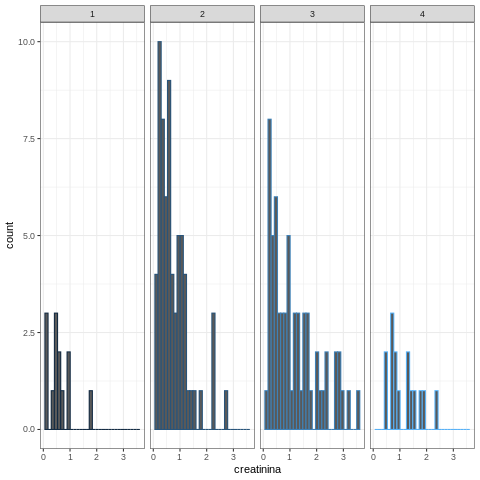

In [192]:
%%R

# data = data_enfermos
# Ploteamos para verificar las formas de las distribuciones de cada subgrupo
plot1 <- ggplot(data = data_enfermos, mapping = aes(x = creatinina, colour = estadio)) +
  geom_histogram() + theme_bw() + facet_grid(. ~ estadio) +
  theme(legend.position = "none")# + stat_bin(binwidth=30)

# Y las medias de cada uno tambien
plot2 <- ggplot(data = data_enfermos, mapping = aes(x = estadio, y = creatinina, colour = estadio)) +
  geom_boxplot() + theme_bw() + theme(legend.position = "none")

# grid.arrange(plot1, plot2, ncol = 2)

plot1

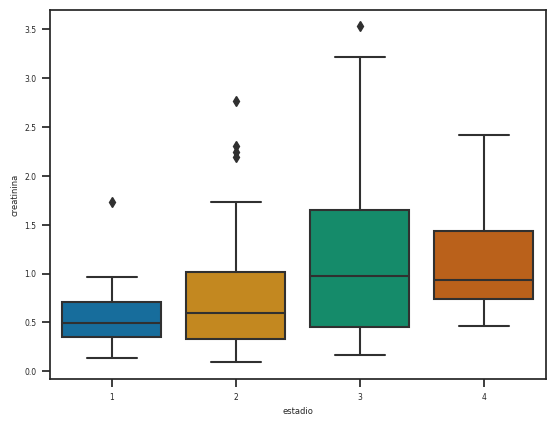

In [195]:
# Vemos el boxplot en Python, ya no puedo pensar en R
sns.boxplot(data=data_enfermos, x='estadio', y='creatinina')
plt.show()

- Test de Kruskal-Wallis

In [197]:
%%R
# Test Kruskal-Wallis -> H0: Forma de Distribuciones =
print(kruskal.test(creatinina ~ estadio, data = data_enfermos))


# Kruskal-Wallis Multiple Comparation
print(kruskalmc(data_enfermos$creatinina ~ data_enfermos$estadio))


	Kruskal-Wallis rank sum test

data:  creatinina by estadio
Kruskal-Wallis chi-squared = 14.421, df = 3, p-value = 0.002384

Multiple comparison test after Kruskal-Wallis 
alpha: 0.05 
Comparisons
     obs.dif critical.dif stat.signif
1-2 12.15093     36.16667       FALSE
1-3 33.88896     36.35815       FALSE
1-4 45.26154     45.16483        TRUE
2-3 21.73803     21.08025        TRUE
2-4 33.11061     34.09287       FALSE
3-4 11.37258     34.29593       FALSE


- Si bien el test de Kurskal-Wallis rechaza la Hipotesis Nula de igualdad de distribuciones de cads subgrupo al 5%, vemos que las diferencias estan muy en el borde

### Variable Sexo como predictora

             Df Sum Sq Mean Sq F value  Pr(>F)    
sexo          1    7.8   7.795   19.67 1.3e-05 ***
Residuals   298  118.1   0.396                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


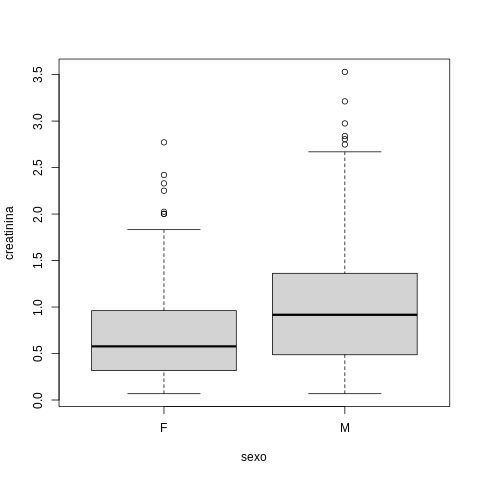

In [201]:
# Modelamos con ANOVA -> H0: Medias de cada grupo = (Test F)
%%R

model_anova<- aov(creatinina ~ sexo, data=data)
print(summary(model_anova))

plot(creatinina ~ sexo, data=data)

- Rechazamos la Hipotesis Nula del Test F de que las medias son iguales para cad subgrupo. Verificamos los assumptions realizando test de Normalidad y Homocedasticidad de los residuso

In [204]:
%%R

# Test de Levene (Homocedasticidad, robusto) -> H0: Varianzas  de cada grupo =
print(leveneTest(creatinina ~ sexo, data=data))

# Test Shapiro: H0 Normalidad Distribucion de los residuos
print(shapiro.test(residuals(model_anova)))


Levene's Test for Homogeneity of Variance (center = median)
       Df F value   Pr(>F)   
group   1   7.717 0.005817 **
      298                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	Shapiro-Wilk normality test

data:  residuals(model_anova)
W = 0.91085, p-value = 2.409e-12



- No se cumplen los supuestos de Normalidad ni Homocedasticidad de los residuos, aplicamos ANOVA no Parametrico

### Anova no parametrico

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


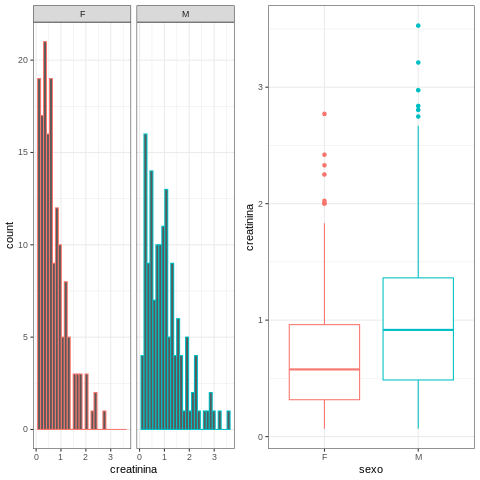

In [205]:
%%R

library(ggplot2)
library(gridExtra)

# Ploteamos para verificar las formas de las distribuciones de cada subgrupo
plot1 <- ggplot(data = data, mapping = aes(x = creatinina, colour = sexo)) +
  geom_histogram() + theme_bw() + facet_grid(. ~ sexo) +
  theme(legend.position = "none")# + stat_bin(binwidth=30)

# Y las medias de cada uno tambien
plot2 <- ggplot(data = data, mapping = aes(x = sexo, y = creatinina, colour = sexo)) +
  geom_boxplot() + theme_bw() + theme(legend.position = "none")

grid.arrange(plot1, plot2, ncol = 2)

- Las distribuciones parecen ser similares, pero observa la presenia de muchos Outliers

In [207]:
%%R
# Test Kruskal-Wallis -> H0: Forma de Distribuciones =
print(kruskal.test(creatinina ~ sexo, data = data))


# Kruskal-Wallis Multiple Comparation
print(kruskalmc(data$creatinina ~ data$sexo))


	Kruskal-Wallis rank sum test

data:  creatinina by sexo
Kruskal-Wallis chi-squared = 18.828, df = 1, p-value = 1.431e-05

Multiple comparison test after Kruskal-Wallis 
alpha: 0.05 
Comparisons
     obs.dif critical.dif stat.signif
F-M 43.50808     19.65369        TRUE


- Realizamos el test de Kurskall-Wallis y rechazamos la igualdad de medias en cada subgrupo

#### Interaccion entre sexo y estadio

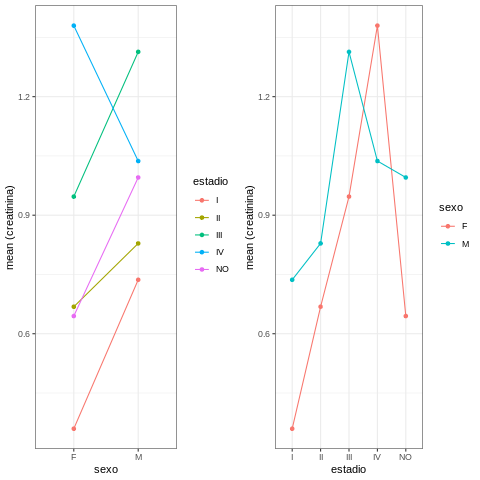

In [208]:
%%R

# Interaccion Templado con Grosor
plot1 <- ggplot(data = data, aes(x = sexo, y = creatinina, colour = estadio,
group = estadio)) +
stat_summary(fun = mean, geom = 'point') +
stat_summary(fun = mean, geom = 'line') +
labs(y = 'mean (creatinina)') + theme_bw()

# Interaccion Grsor con Templado
plot2 <- ggplot(data = data, aes(x = estadio, y = creatinina, colour = sexo,
group = sexo)) +
stat_summary(fun = mean, geom = 'point') +
stat_summary(fun = mean, geom = 'line') +
labs(y = 'mean (creatinina)') + theme_bw()

grid.arrange(plot1, plot2, ncol = 2)

- Vemos como las lineas se cruzan, esto confirma que hay interaccion entre las variables categoricas Sexo y Estadio

# Son las 9:58PM (ARG) y no me da mas el tiempo